In [8]:
%reload_ext autoreload
%autoreload 2

import hashlib
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import yaml

from firebase_admin import db
from library.config import get_config_declaration, get_config_options
from library.firebase import initialize_app, get_dataset_ref
from matplotlib.axes import Axes
from os import makedirs
from os.path import exists
from typing import Dict, Tuple

In [9]:
VIDEO_FILES = [
    "VISO/car/003",
    "VISO/car/004",
    "VISO/car/005",
    "VISO/car/006",
    "VISO/car/007",
    "VISO/car/008",
    "VISO/car/009",
]

ENABLE_TRACKING = True
ENABLE_PERSIST = False

RUNTIME_CONFIG = {
    "display": False,
    "save": True,
    "timings": False,
    "progress": True,
    "enable_tracking": ENABLE_TRACKING,
    "enable_persist": ENABLE_PERSIST
}

initialize_app()

In [10]:
# From github.com/KastnerRG/sherlock/utils
import library.pareto as pareto

def compute_scores(y, rows, margin=0):
    ndrange = np.ptp(y, axis=0) * margin
    total_sum = np.sum(y, axis=0)
    nrows = y.shape[0]
    scores = np.empty(len(rows), dtype=float)
    for i, r in enumerate(rows):
        scores[i] = np.sum(r * nrows - total_sum + ndrange * (nrows - 1))
    return scores

def approximate_pareto(y, epsilons=None, margin=0):
    """
    Uses pareto.py from https://github.com/matthewjwoodruff/pareto.py
    Returns the same data as prpt.
    """
    tagalongs = np.array(pareto.eps_sort(y, epsilons=epsilons, maximize_all=True, attribution=True))
    pareto_solutions = tagalongs[:, :y.shape[1]]
    pareto_idx = tagalongs[:, y.shape[1] + 1].astype(int)
    if margin > 0:
        miny = np.min(y, axis=0)
        ptp = pareto_solutions - miny
        margin = ptp * margin
        pareto_idx = range(y.shape[0])
        for s, m in zip(pareto_solutions, margin):
            pareto_idx = np.intersect1d(pareto_idx, np.where(np.any(y >= s - m, axis=1))[0], assume_unique=True)
        pareto_solutions = y[pareto_idx, :]
    pareto_scores = compute_scores(y, pareto_solutions)
    return pareto_solutions, pareto_idx, pareto_scores

In [11]:
def get_design_space(
    video_file: str, enable_tracking: bool, enable_persist: bool
):
    cache_path = "./output/plot_cache.pickle"
    cache: Dict[
        Tuple[str, int, str, bool, bool, int], Tuple[float, float, float]
    ] = None
    if exists(cache_path):
        with open(cache_path, "rb") as f:
            cache = pickle.load(f)
    else:
        cache = {}

    with open("./config_declaration.yml", "r", encoding="utf8") as f:
        config_declaration = get_config_declaration("", yaml.safe_load(f))
        f.seek(0)

    config_options = [
        (k, get_config_options(i), i["type"])
        for k, i in config_declaration.items()
        if "skip_learn" not in i or not i["skip_learn"]
    ]
    X = np.array(np.meshgrid(*[c for _, c, _ in config_options])).T.reshape(
        -1, len(config_options)
    )
    y = np.zeros((X.shape[0], 3))

    with open("./config_declaration.yml", "rb") as f:
        config_hash = hashlib.md5(f.read()).hexdigest()

    sherlock_ref = db.reference("sherlock")

    video_file_ref = get_dataset_ref(video_file, sherlock_ref)
    config_declaration_ref = video_file_ref.child(config_hash)

    if enable_tracking:
        tracking_ref = config_declaration_ref.child("tracking_enabled")
    else:
        tracking_ref = config_declaration_ref.child("tracking_disabled")

    if enable_persist:
        persist_ref = tracking_ref.child("persist_enabled")
    else:
        persist_ref = tracking_ref.child("persist_disabled")

    known_idx_ref = persist_ref.child("known_idx")
    current_idx_ref = persist_ref.child("current_idx")

    updated_cache = False
    known_idx = [i for i in (known_idx_ref.get() or []) if i is not None]
    current_idx = current_idx_ref.get() or []
    for idx in known_idx:
        cache_key = (
            config_hash,
            video_file,
            enable_tracking,
            enable_persist,
            idx,
        )

        if cache_key in cache:
            recall, precision, f1 = cache[cache_key]
        else:
            idx_ref = persist_ref.child(str(idx))
            recall, precision, f1 = idx_ref.get()
            cache[cache_key] = (recall, precision, f1)
            updated_cache = True

        y[idx, :] = np.array([recall, precision, f1])

    if updated_cache:
        with open(cache_path, "wb") as f:
            pickle.dump(cache, f)

    current_idx = np.array(current_idx)
    known_idx = np.array(known_idx)
    current_outputs = np.array(y[current_idx, :])
    known_outputs = np.array(y[known_idx, :])
    # known_X = X[known_idx, :]
    ypredict, ypredict_idx, _ = approximate_pareto(current_outputs)
    ypredict_idx = known_idx[ypredict_idx].flatten()

    return y, current_idx, current_outputs, known_outputs, known_idx, ypredict, ypredict_idx, persist_ref

def get_results(
    video_file: str,
    enable_tracking: bool,
    enable_persist: bool,
    reference_video_file: str,
    ax: Axes,
):
    if reference_video_file:
        reference_video_idx = VIDEO_FILES.index(reference_video_file)

    video_idx = VIDEO_FILES.index(video_file)

    (
        y,
        current_idx,
        current_outputs,
        known_outputs,
        known_idx,
        ypredict,
        ypredict_idx,
        storage_ref,
    ) = get_design_space(video_file, enable_tracking, enable_persist)

    ax.scatter(
        current_outputs[:, 0],
        current_outputs[:, 1],
        c="blue",
        marker="^",
        label="Sampled designs",
    )
    ax.scatter(
        ypredict[:, 0],
        ypredict[:, 1],
        c="red",
        label="Predicted Pareto designs",
    )

    if reference_video_file and video_idx != reference_video_idx:
        _, _, _, _, _, _, ref_ypredict_idx, _ = get_design_space(
            reference_video_file, enable_tracking, enable_persist
        )

        known_idx_set = {idx for idx in known_idx}
        filtered_idx = [idx for idx in ref_ypredict_idx if idx in known_idx_set]
        requested_idx = [
            int(idx) for idx in ref_ypredict_idx if idx not in known_idx_set
        ]

        requested_idx_ref = storage_ref.child("requested_idx")
        requested_idx_ref.set(requested_idx)

        ax.scatter(
            y[filtered_idx, 0],
            y[filtered_idx, 1],
            c="orange",
            marker="+",
            label=f"Predicted Pareto designs for Video {reference_video_idx + 1}",
        )

    ax.set_title(
        f"Video {video_idx + 1}"
        # + f" with Tracking {'Enabled' if enable_tracking else 'Disabled'}"
        # + f" and Persistence {'Enabled' if enable_persist else 'Disabled'}"
        # + " Design Space"
    )
    ax.set(xlabel="Recall", ylabel="Precision")
    # ax.label_outer()
    # ax.legend()
    # plt.legend(bbox_to_anchor=(1.05, 1.05))
    # plt.xlabel("Recall")
    # plt.ylabel("Precision")
    ax.set_xlim(known_outputs[:, 0].min(), known_outputs[:, 0].max())
    ax.set_ylim(known_outputs[:, 1].min(), known_outputs[:, 1].max())

    # plt.show()

In [12]:
def get_row_col(i: int):
    col = i % 3
    row = math.floor(i / 3)

    return (row, col)

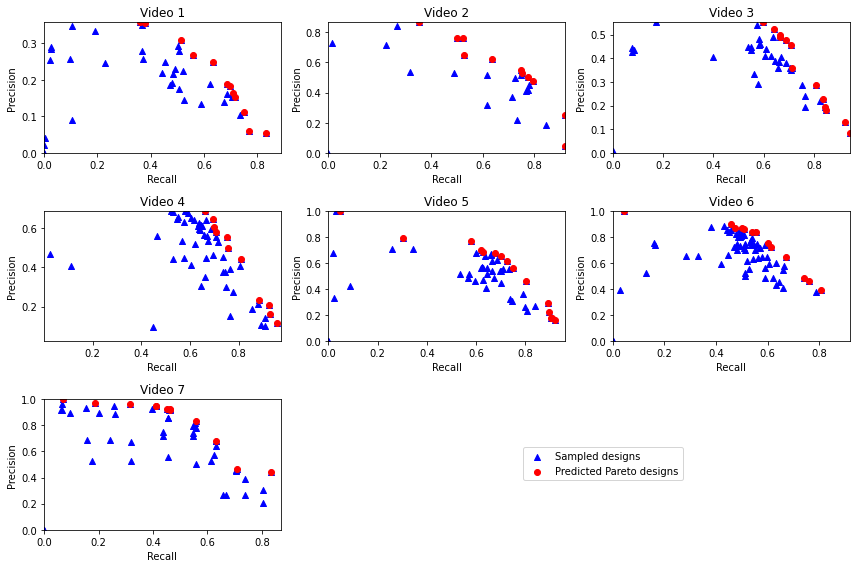

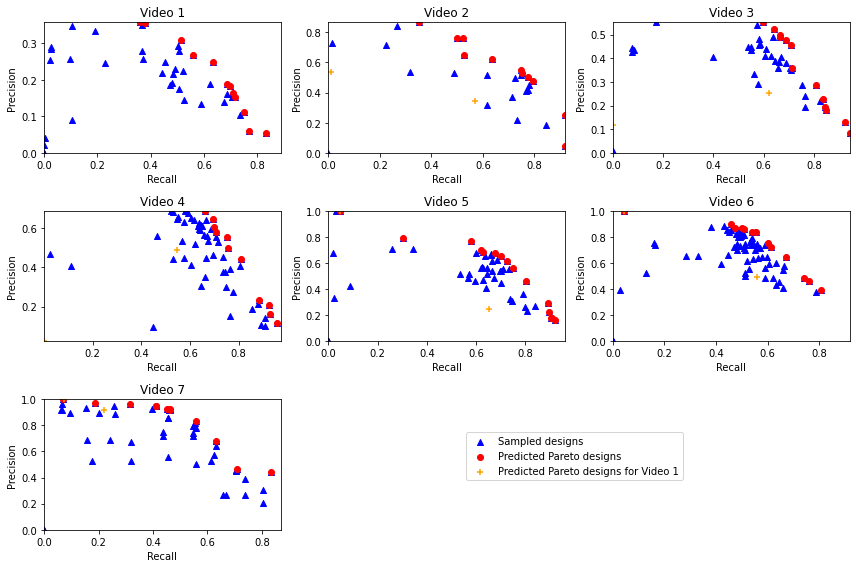

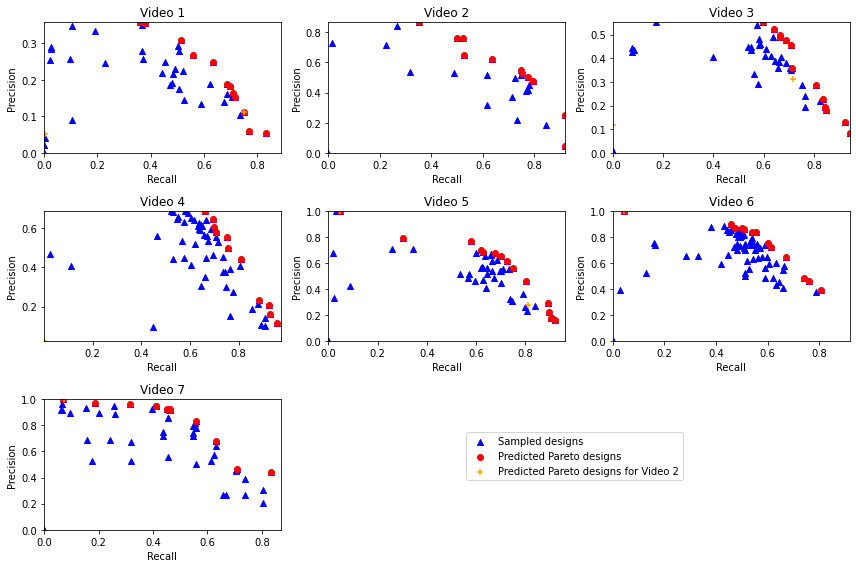

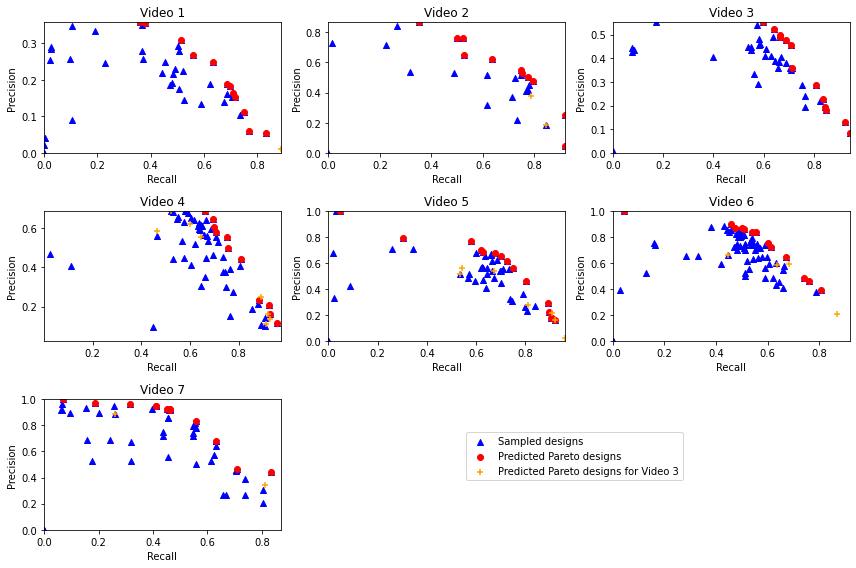

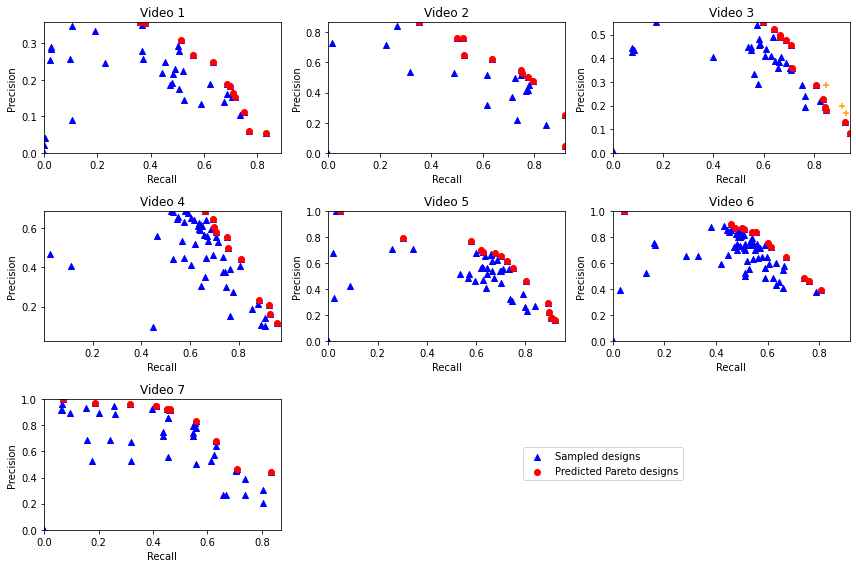

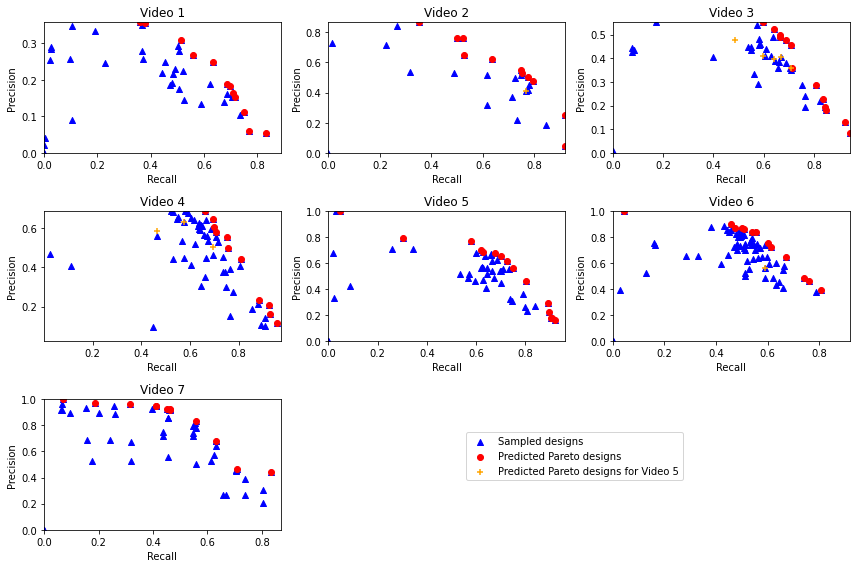

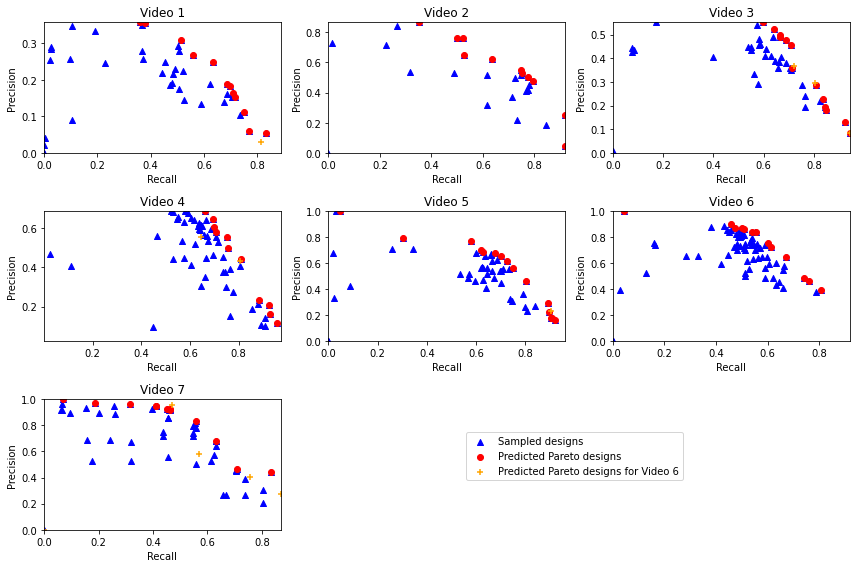

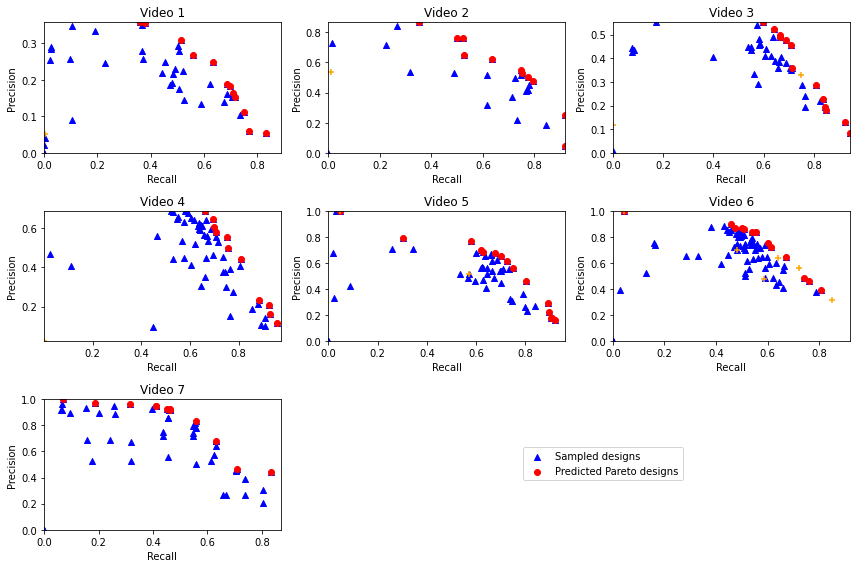

In [13]:
video_files = [None]
video_files.extend(VIDEO_FILES)

for ref_idx, ref_video_file in enumerate(video_files):
    ref_idx -= 1
    if ref_idx != -1:
        ref_r, ref_c = get_row_col(ref_idx)

        if ref_r == 0 and ref_c == 0:
            ref_r = 1

    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
    fig.delaxes(axs[2][1])
    fig.delaxes(axs[2][2])
    for i, video_file in enumerate(VIDEO_FILES):
        r, c = get_row_col(i)

        get_results(
            video_file, ENABLE_TRACKING, ENABLE_PERSIST, ref_video_file, axs[r, c]
        )

    if ref_idx == -1:
        ref_r = 0

    handles, labels = axs[ref_r, 0].get_legend_handles_labels()
    fig.tight_layout()
    fig.legend(
        handles, labels, loc="lower right", bbox_to_anchor=(0.8, 0.15)
    )

    makedirs("./output/figures", exist_ok=True)

    if ref_idx == -1:
        path = f"./output/figures/fig_{'tracking' if ENABLE_TRACKING else 'detection'}_pareto.pdf"
    else:
        path = f"./output/figures/fig_{'tracking' if ENABLE_TRACKING else 'detection'}_pareto_ref{ref_idx + 1}.pdf"

    plt.savefig(path, format="pdf")



In [14]:
names = []
idxes = []
recalls = []
precisions = []
f1s = []

for i, video_file in enumerate(VIDEO_FILES):
    (
        y,
        current_idx,
        current_outputs,
        _,
        _,
        ypredict,
        ypredict_idx,
        storage_ref,
    ) = get_design_space(video_file, ENABLE_TRACKING, ENABLE_PERSIST)

    for idx, (output) in zip(current_idx, current_outputs):
        idx = idx
        recall = output[0]
        precision = output[1]
        f1 = output[2]

        names.append(f"Video {i + 1}")
        idxes.append(idx)
        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)

df = pd.DataFrame()
df["Video Name"] = names
df["idx"] = idxes
df["Recall"] = recalls
df["Precision"] = precisions
df["F1"] = f1s

df.to_csv("./output/pareto_front.csv")